In [1]:
from scipy.stats import norm, gamma
import time, datetime
import numpy as np, pandas as pd
import seaborn as sns
import pyodbc
import gc

from simpoe.corrosion import failureStress, corrLimitStates
from simpoe import unpacker, model_constants, distributer, cgr

pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import mpld3
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

mpld3.disable_notebook()
plt.rcParams["figure.figsize"] = (20,10)

# Questions

  * Q1. There are multiple distributions for outside diameter, grade, and wall thickness. What is the reasoning for using one over another?

A: For OD, there is only 1 probabilistic distribution. For wall thickness, the mean 1.1, COV 1.0% is the most generic. Unsure about the grade distribution choice at this time.

* Q2. How to use the COV% values when distributions are Weibull?

A: COV = (standard deviation / mean)_x_100. CSA Z662 provides ranges for mean and COV to use with a Weibull distribution. From these, one can use statistics to derive the **shape** and **scale** factors

 * Q3. How to roll individual POEs into failure frequencies?

A: Original method would be to divide the POE by the assessment length. However, this could lead to distortion problems when the assessment length is very small. 

I recently found a formula referenced in some of our methodology sections that _normalizes_ POEs from an assessment length to 1 km:

P_1km = 1 - (1 - POE)^(1.00/Assessment Length)

However, I'm trying to look for the reasoning behind this formula. Additionally, from whom I've asked, I've gotten mixed opinions about this formula.

# Functions

In [2]:
#the norm and gamma are functions from the scipy.stats module. norm is the normal distribution, and gamma is the gamma function.
from scipy.stats import norm, gamma

#python module for accessing and working with time.
import datetime

#numpy is a python module to work with arrays. pandas is a python module to work with tabular data.
import numpy as np, pandas as pd

#simpoe is a custom module I created to facilitate some of the functions required for POE. Please find the files for each of these modules in the "poe dependencies" folder.
from simpoe.corrosion import failureStress, corrLimitStates
from simpoe import unpacker, model_constants, distributer, cgr

#corrpoe is the function I call to calculate POE. 
def corrpoe(df, n, cga_rate=10):
    """
    Calculates POE using Monte Carlo approach
    :param df: input pandas dataframe with input columns.
	:param n:  number of iterations to run Monte Carlo on.
	:param cga_rate:	default value to use for fixed growth rate. Omitt, as it shouldn't be used in calculation anyways.
    :return: returns a pandas dataframe (tabular object) with the inputs for each feature, and 33 columns for leak, rupture, and total POE for the year of analysis, and each of year 1 through year 10 after year of analysis.
    """
    # Number of features is equal to number of rows in csv file
    i = df.shape[0]
    now = datetime.date.today()
    
    # Pipe properties extracted from the dataframe df. Please follow the "unpacker.py" file for explanation as to how this is carried out.
    OD, WTm, Sm, Tm, OPm, Inst = unpacker.pipe_prop(df)
    pipe_age = ((now - Inst).dt.days.values) / 365.25
    
    # Feature properties extracted from the dataframe df. Please follow the "unpacker.py" file for explanation as to how this is carried out.
    fPDP, fL_measured, fW_measured, fstatus, ftype, fchainage = unpacker.feature_dim(df)
    fID = df['FeatureID'].values
    f_v_CGR = df['vendor_cgr_mmpyr'].fillna(np.nan).values
    f_v_sd_CGR = df['vendor_cgr_sd'].fillna(np.nan).values
    shape = df['shape'].values
    scale = df['scale'].values
    
    # Inline inspection range properties extracted from the dataframe df. Please follow the "unpacker.py" file for explanation as to how this is carried out.
    Insp, vendor, tool = unpacker.range_prop(df)

    # Calculating the time difference between date of ILI and today, in fractional years.
    time_delta = ((now - Insp).dt.days.values) / 365.25

	# defining the function for model error. This function uses the gamma.ppf() function part of the import statement above. The equivalent Excel function is GAMMA.INV()
    def model_error(p):
        return 0.914 + gamma.ppf(p, 2.175, scale=0.225)

    # unit conversion to US units
    WT = WTm / 25.4
    S = (Sm * 1000) / 6.89476
    OP = OPm / 6.89476

    # Statistics fueled by CSA Z662 Annex O Tables O.6 and O.7
    meanWT = 1.01
    sdWT = 0.01
    meanS = 1.10 #recommended from CSA Z662 2019
    sdS = 0.035 #recommended from CSA Z662 2019

    tool_D = 0.078 # in fraction WT
    tool_L = 7.80 / 25.4 # in inches

    # OD and MOP are not distributed. This function creates an array with the same value as the input
    OD, OP = distributer.tiler(OD, OP, tuple_size=(n, 1))

    # Setting a random seed
    np.random.seed()

	#  Initializing arrays of size (n, i), containing random numbers from 0 to 1, for each of model error, wall thickness, grade, feature length, feature depth, and growth rate.
    mE_n_1, WT_n_2, S_n_3, fL_n_5, fD_n_6, fGR_n_7 = distributer.random_prob_gen(6, iterations=n, features=i)

    # the following 2 statements distribute the wall thickness and grade, using normal distributions. Equivalent Excel equation is NORM.INV()
    WTd = norm.ppf(WT_n_2, loc=WT * meanWT, scale=WT * sdWT)
    Sdist = norm.ppf(S_n_3, loc=S * meanS, scale=S * sdS)

    # the following statement distributes the feature length in inches, using normal distribution, and ensures the length is not distributed below 0.0 mm.
    fL = np.maximum(0, norm.ppf(fL_n_5, loc=fL_measured * 1.0 * (1 / 25.4), scale=tool_L))

    # the following statement distributes the feature depth in inches, using normal distribution, and ensures the depth is not distributed below 0.0 mm.
    fD_run = np.maximum(0, norm.ppf(fD_n_6, loc=fPDP * WT * 1.0, scale=tool_D * WT))

#     fD_GR = cgr.cgr_weibull(fGR_n_7, 1.439, 0.1) / 25.4
    # the following statement applies the growth rate assumptions. Please refer to the "cgr.py" file for the details on the cgr_mpy() and cgr_weibull() functions
    fD_GR = np.where(np.isnan(f_v_CGR),
                     np.where(fD_run>0.40,
                            (fD_run)/((Insp-Inst).dt.days.values/365.25),
                            np.maximum(0,cgr.cgr_weibull(fGR_n_7, shape, scale) / 25.4)),
                             np.maximum(0, norm.ppf(fGR_n_7, loc=f_v_CGR * 1.0 * (1/25.4), scale=f_v_sd_CGR * (1/25.4))))
    
    # Please omitt the following commented code. I've kept this for traceability of different methods.
    # if mechanism == "CGA":
    #     fD_GR = cgr.cgr_mpy(cga_rate) / 25.4
    # elif mechanism == "weibull":
    #     fD_GR = cgr.cgr_weibull(fGR_n_7, shp_1, scl_1) / 25.4
    # elif mechanism == "logic":   
    #     fD_GR = np.where(pipe_age<=5,
    #                     np.where(fD_run>0.20,
    #                             (fD_run)/((Insp-Inst).dt.days.values/365.25),
    #                             np.minimum(cgr.cgr_mpy(cga_rate) / 25.4, cgr.cgr_weibull(fGR_n_7, shp_1, scl_1) / 25.4)),
    #                     np.where((pipe_age>5) & (pipe_age<=incubation_cap),
    #                             cgr.cgr_weibull(fGR_n_7, shp_2, scl_2) / 25.4,
    #                             cgr.cgr_weibull(fGR_n_7, shp_3, scl_3) / 25.4))
    # elif mechanism == "half-life":
    #     fD_GR = cgr.half_life(fD_run, Inst, Insp)  # fD_run is in inches
    # elif mechanism == "full-life":
    #     fD_GR = (fD_run)/((Insp-Inst).dt.days.values/365.25)
    # elif mechanism == "2.2%WT":
    #     fD_GR = cgr.pct_wt(WT)
    # else:
    #     raise Exception("Please select a valid mechanism: full-life | half-life | 2.2%WT | CGA | logic | weibull")

    # calculating the depth at the year of analysis
    fD = fD_run + fD_GR * time_delta

    # calculating the model error
#     modelError = model_error(mE_n_1)

    # calculating the Failure Stress in psi. Please refer to the "failureStress.py" file for the details on the calculation.
    failure_stress = failureStress.modified_b31g(OD, WTd, Sdist, fL, fD, units="US")

    # calculating Failure pressure in psi, using the Barlow formula
    failPress = 2 * failure_stress * WTd / OD

    # comparing the failure pressures to the operating pressure of the pipeline. Please refer to the "corrLimitStates.py" file for details on the limit state checking.
    ruptures, rupture_count = corrLimitStates.ls_corr_rupture(failPress, OP, bulk=True)

    # comparing the depth at year of analysis with the wall thickness to see if the 80.0%WT criteria is exceeded. Please refer to the "corrLimitStates.py" file for details on the limit state checking.
    leaks, leak_count = corrLimitStates.ls_corr_leak(WTd, fD, bulk=True)

    # checking both leak and rupture limit states at the same time. Please refer to the "corrLimitStates.py" file for details.
    fails, fail_count = corrLimitStates.ls_corr_tot(ruptures, leaks, bulk=True)

    # setting up the projection of 10 years after year of analysis.
    failure_projection = {'leaks':[None]*20,
                         'ruptures':[None]*20,
                         'fails':[None]*20}
    
    # Calculate POE for each of 10 years from year of analysis
    for x in range(20):
        # Add 1 year of corrosion growth
        fD += fD_GR*(1.0)
        
        # recalculate Failure Stress in psi
        failure_stress = failureStress.modified_b31g(OD, WTd, Sdist, fL, fD, units="US")

        # recalculate Failure pressure in psi
        failPress = 2 * failure_stress * WTd / OD

        # redetermine limit state exceedances
        rupture_proj, failure_projection['ruptures'][x] = corrLimitStates.ls_corr_rupture(failPress, OP, bulk=True)
        leak_proj, failure_projection['leaks'][x] = corrLimitStates.ls_corr_leak(WTd, fD, bulk=True)
        _, failure_projection['fails'][x] = corrLimitStates.ls_corr_tot(rupture_proj, leak_proj, bulk=True)
        
    # setting up a container to hold all the information to be returned as results
    return_dict = {"FeatureID":fID,
                   "PDP_frac": fPDP,
                   "flength": fL_measured,
                   "iterations": np.size(fails, axis=0),
                   "rupture_count_YOA": rupture_count,
                   "leak_count_YOA": leak_count,
                   "fail_count_YOA": fail_count,
                   "rupture_count_Y1": failure_projection['ruptures'][0],
                   "leak_count_Y1": failure_projection['leaks'][0],
                   "fail_count_Y1": failure_projection['fails'][0],
                   "rupture_count_Y2": failure_projection['ruptures'][1],
                   "leak_count_Y2": failure_projection['leaks'][1],
                   "fail_count_Y2": failure_projection['fails'][1],
                   "rupture_count_Y3": failure_projection['ruptures'][2],
                   "leak_count_Y3": failure_projection['leaks'][2],
                   "fail_count_Y3": failure_projection['fails'][2],
                   "rupture_count_Y4": failure_projection['ruptures'][3],
                   "leak_count_Y4": failure_projection['leaks'][3],
                   "fail_count_Y4": failure_projection['fails'][3],
                   "rupture_count_Y5": failure_projection['ruptures'][4],
                   "leak_count_Y5": failure_projection['leaks'][4],
                   "fail_count_Y5": failure_projection['fails'][4],
                   "rupture_count_Y6": failure_projection['ruptures'][5],
                   "leak_count_Y6": failure_projection['leaks'][5],
                   "fail_count_Y6": failure_projection['fails'][5],
                   "rupture_count_Y7": failure_projection['ruptures'][6],
                   "leak_count_Y7": failure_projection['leaks'][6],
                   "fail_count_Y7": failure_projection['fails'][6],
                   "rupture_count_Y8": failure_projection['ruptures'][7],
                   "leak_count_Y8": failure_projection['leaks'][7],
                   "fail_count_Y8": failure_projection['fails'][7],
                   "rupture_count_Y9": failure_projection['ruptures'][8],
                   "leak_count_Y9": failure_projection['leaks'][8],
                   "fail_count_Y9": failure_projection['fails'][8],
                   "rupture_count_Y10": failure_projection['ruptures'][9],
                   "leak_count_Y10": failure_projection['leaks'][9],
                   "fail_count_Y10": failure_projection['fails'][9],
                   "rupture_count_Y11": failure_projection['ruptures'][10],
                   "leak_count_Y11": failure_projection['leaks'][10],
                   "fail_count_Y11": failure_projection['fails'][10],
                   "rupture_count_Y12": failure_projection['ruptures'][11],
                   "leak_count_Y12": failure_projection['leaks'][11],
                   "fail_count_Y12": failure_projection['fails'][11],
                   "rupture_count_Y13": failure_projection['ruptures'][12],
                   "leak_count_Y13": failure_projection['leaks'][12],
                   "fail_count_Y13": failure_projection['fails'][12],
                   "rupture_count_Y14": failure_projection['ruptures'][13],
                   "leak_count_Y14": failure_projection['leaks'][13],
                   "fail_count_Y14": failure_projection['fails'][13],
                   "rupture_count_Y15": failure_projection['ruptures'][14],
                   "leak_count_Y15": failure_projection['leaks'][14],
                   "fail_count_Y15": failure_projection['fails'][14],
                   "rupture_count_Y16": failure_projection['ruptures'][15],
                   "leak_count_Y16": failure_projection['leaks'][15],
                   "fail_count_Y16": failure_projection['fails'][15],
                   "rupture_count_Y17": failure_projection['ruptures'][16],
                   "leak_count_Y17": failure_projection['leaks'][16],
                   "fail_count_Y17": failure_projection['fails'][16],
                   "rupture_count_Y18": failure_projection['ruptures'][17],
                   "leak_count_Y18": failure_projection['leaks'][17],
                   "fail_count_Y18": failure_projection['fails'][17],
                   "rupture_count_Y19": failure_projection['ruptures'][18],
                   "leak_count_Y19": failure_projection['leaks'][18],
                   "fail_count_Y19": failure_projection['fails'][18],
                   "rupture_count_Y20": failure_projection['ruptures'][19],
                   "leak_count_Y20": failure_projection['leaks'][19],
                   "fail_count_Y20": failure_projection['fails'][19],
                   "nan": np.zeros((i,))
                   }
    # converting the container to a tabulat object using pandas
    return_df = pd.DataFrame(return_dict).set_index('FeatureID')

    return return_df

In [3]:
def critical_depth_modified_b31g(od, wt, s, p, fL, units="SI"):
    """
    Calculates the failure stress using the Modified B31G Equation
    :param od:  Pipe outside diameter, in mm (SI), or inches (US)
    :param wt:  Pipe wall thickness, in mm (SI), or inches (US)
    :param s:   Pipe grade, in kPa (SI), or psi (US)
    :param p:   pressure, in kPa (SI), or psi (US)
    :param fL:  feature length, in mm (SI), or inches (US)
    :param units: flag for which units to use, "SI" or "US", default "SI"
    :return: Critical depth, in mm (SI), or inches (US)
    """

    l2Dt = np.power(fL, 2.0)/(od*wt)
    Mt = np.where(l2Dt <= 50.0,
                  np.sqrt( 1.0 +(0.6275*l2Dt)-(0.003375*np.power(l2Dt, 2.0))),
                  0.032*l2Dt+3.3)
    if units=="SI":
        flowS = s + 68947.6
    else:
        flowS = s + 10000.0

    opStress = (p*od)/(2.*wt)
    
    critical_d = ((opStress-flowS)*wt)/(0.85*((opStress/Mt)-flowS))
    return np.minimum(critical_d/wt,0.8)

In [4]:
def sql_query(q,server = 'sql2014',db = 'ppl_irasv6_prod'):
    driver = '{SQL Server Native Client 11.0}'
    conn = pyodbc.connect("Driver="+driver+";Server="+server+";Database="+db+";Trusted_Connection=yes;")
    temp = pd.read_sql_query(q,conn)
    conn.close()
    return temp

In [5]:
def get_ili_ranges(line):
    q1 = f"""set nocount on;
            select ll.LineName, ld.code [status], r.* from InlineInspectionRange r
            join StationSeries ss on r.BeginStationSeriesId = ss.Id
            join LineLoop ll on ss.LineLoopId = ll.Id
            join ListDomain ld on r.ILIRStatusDomainId = ld.Id
            where ll.LineName like '%{line}%'
            order by r.ILIRStartDate desc"""

    return sql_query(q1)


In [6]:
def get_features_from_ilir(ilirid):
    q2 = f"""select
            a.PipeInserviceDate,
            a.PipeWallThickness,
            r.ilirstartdate,
            ld.code [status], 
            ld2.code [type], 
            f.ILIFSurfaceInd, 
            (f.StationNum*mlv.MultiplierNum+mlv.FactorNum) [chainage], 
            f.ILIFPeakDepthPct 
            from InlineInspectionFeature f

            join ListDomain ld on f.ILIFStatusDomainId = ld.Id
            join ListDomain ld2 on f.ILIFTypeDomainId = ld2.Id
            join StationSeries ss on f.StationSeriesId = ss.id
            join LineLoop ll on ss.LineLoopId = ll.Id
            join inlineinspectionrange r on f.inlineinspectionrangeid = r.id
            join MLVCorrection mlv on f.StationSeriesId = mlv.StationSeriesId
            join 
                (select ll.id [LinloopId], ps.EffectiveStartDate, ps.PipeInserviceDate, ps.PipeOutsideDiameter, ps.PipeWallThickness, ps.PipeGrade, (ps.BeginStationNum*mlv1.MultiplierNum+mlv1.FactorNum) [begin_c], (ps.EndStationNum*mlv2.MultiplierNum+mlv2.FactorNum) [end_c] from PipeSegment ps
                join StationSeries ss on ps.BeginStationSeriesId = ss.id
                join LineLoop ll on ss.LineLoopId = ll.Id
                join MLVCorrection mlv1 on ps.BeginStationSeriesId = mlv1.StationSeriesId
                join MLVCorrection mlv2 on ps.EndStationSeriesId = mlv2.StationSeriesId
                ) a on ((f.StationNum*mlv.MultiplierNum+mlv.FactorNum) between a.begin_c and a.end_c) and a.LinloopId = ll.id

            where f.InlineInspectionRangeId = {ilirid}"""

    return sql_query(q2)

In [7]:
def get_features_for_poe(ILIRID, start=1, amt=999999999):
    query = f"""select
            c.RN,
            ll.linename [line],

            ld4.code [vendor], 

            format(r.ILIRStartDate,'yyyy-MM-dd') [ILIRStartDate],
            ld3.code [tool],

            f.ILIFFeatureNumber [FeatureID],
            ld.code [status], 
            ld2.code [type],
            (f.StationNum*mlv.MultiplierNum+mlv.FactorNum) [chainage_m], 
            f.ILIFSurfaceInd, 
            f.ILIFPeakDepthPct [depth_fraction], 
            f.ILIFLength [length_mm], 
            f.ILIFWidth [width_mm],
            f.GrowthRate [vendor_cgr_mmpyr],
            f.GrowthRateStdDev [vendor_cgr_sd],

            format(a.PipeInserviceDate,'yyyy-MM-dd') [install_date],
            a.PipeOutsideDiameter [OD_inch],
            a.PipeWallThickness [WT_mm],
            a.PipeGrade [grade_MPa],
            a.PipeToughness [toughness_J],
            a.[begin_ps_c],
            a.[end_ps_c],

            d.coating_type,
            d.POECoatingYearsCrsnFree [incubation_yrs],
            d.begin_co_c,
            d.end_co_c,

            b.MAOP_kPa,
            b.begin_maop_c,
            b.end_maop_c  

            from InlineInspectionFeature f

            left join ListDomain ld on f.ILIFStatusDomainId = ld.Id
            left join ListDomain ld2 on f.ILIFTypeDomainId = ld2.Id
            left join StationSeries ss on f.StationSeriesId = ss.id
            left join LineLoop ll on ss.LineLoopId = ll.Id
            left join inlineinspectionrange r on f.inlineinspectionrangeid = r.id
            left join ListDomain ld3 on r.ILIRToolDomainId = ld3.Id
            left join InlineInspection i on f.InlineInspectionId = i.Id
            left join ListDomain ld4 on i.ILICompanyDomainId = ld4.Id
            left join MLVCorrection mlv on f.StationSeriesId = mlv.StationSeriesId

            left join 
                (select ll.id [LinloopId],
                ll.LineName,
                ps.EffectiveStartDate,
                ps.PipeInserviceDate,
                ps.PipeOutsideDiameter,
                ps.PipeWallThickness,
                ps.PipeGrade,
                ps.PipeToughness,
                (ps.BeginStationNum*mlv1.MultiplierNum+mlv1.FactorNum) [begin_ps_c],
                (ps.EndStationNum*mlv2.MultiplierNum+mlv2.FactorNum) [end_ps_c]
                from PipeSegment ps
                join StationSeries ss on ps.BeginStationSeriesId = ss.id
                join LineLoop ll on ss.LineLoopId = ll.Id
                join MLVCorrection mlv1 on ps.BeginStationSeriesId = mlv1.StationSeriesId
                join MLVCorrection mlv2 on ps.EndStationSeriesId = mlv2.StationSeriesId
                where ps.EffectiveEndDate is null
                ) a on ((f.StationNum*mlv.MultiplierNum+mlv.FactorNum) between a.[begin_ps_c] and a.[end_ps_c]) and a.LinloopId = ll.id

            left join 
                (select ll.id [LinloopId],
                ll.LineName,
                maop.EffectiveEndDate,
                maop.BeginStationSeriesId,
                maop.MaxAllowablePressure [MAOP_kPa],
                maop.BeginStationNum*mlv1.MultiplierNum+mlv1.FactorNum [begin_maop_c],
                maop.EndStationNum*mlv2.MultiplierNum+mlv2.FactorNum [end_maop_c]
                from maop maop
                join StationSeries ss on ss.id = maop.BeginStationSeriesId
                join LineLoop ll on ss.LineLoopId = ll.Id
                join MLVCorrection mlv1 on maop.BeginStationSeriesId = mlv1.StationSeriesId
                join MLVCorrection mlv2 on maop.EndStationSeriesId = mlv2.StationSeriesId
                where maop.EffectiveEndDate is null
                ) b on ((f.StationNum*mlv.MultiplierNum+mlv.FactorNum) between b.[begin_maop_c] and b.[end_maop_c]) and b.[LinloopId] = ll.id 

            left join
                (select ROW_NUMBER() over(partition by ff.InlineInspectionRangeId order by ff.id asc)  [RN],
                ff.id,
                ff.InlineInspectionRangeId
                from InlineInspectionFeature ff
                )  c on f.Id = c.Id and f.InlineInspectionRangeId = c.InlineInspectionRangeId

            left join 
                (select ll.id [LinloopId],
                ll.LineName,
                co.EffectiveStartDate,
                ld.code [coating_type],
                (co.BeginStationNum*mlv1.MultiplierNum+mlv1.FactorNum) [begin_co_c],
                (co.EndStationNum*mlv2.MultiplierNum+mlv2.FactorNum) [end_co_c],
                poe_c.POECoatingYearsCrsnFree
                from Coating co
                join StationSeries ss on co.BeginStationSeriesId = ss.id
                join LineLoop ll on ss.LineLoopId = ll.Id
                join ListDomain ld on co.CoatingLineDomainId = ld.Id
                join MLVCorrection mlv1 on co.BeginStationSeriesId = mlv1.StationSeriesId
                join MLVCorrection mlv2 on co.EndStationSeriesId = mlv2.StationSeriesId
                
                join POECoatingProperty poe_c on co.CoatingLineDomainId = poe_c.CoatingLineDomainId
                
                where co.EffectiveEndDate is null
                ) d on ((f.StationNum*mlv.MultiplierNum+mlv.FactorNum) between d.[begin_co_c] and d.[end_co_c]) and d.LinloopId = ll.id

            where f.InlineInspectionRangeId = {ILIRID} and (c.RN between {start} and {start+amt})
            order by chainage_m asc"""
    
    return sql_query(query)

In [8]:
def weibull_fitter(var):
    def best_fit_m_b(xs,ys):
        m = ( ((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
              ((np.mean(xs)**2) - np.mean(xs**2)))

        b = np.mean(ys) - m*np.mean(xs)

        return m, b

#     def sqerror(ys_orig,ys_line):
#         return sum((ys_line-ys_orig)**2)


#     def rsquared(ys_orig,ys_line):
#         y_mean_line = np.array([np.mean(ys_orig) for y in ys_orig])
#         sq_error_regr = sqerror(ys_orig,ys_line)
#         sq_error_y_mean = sqerror(ys_orig,y_mean_line)
#         return 1 - (sq_error_regr/sq_error_y_mean)

    var = pd.DataFrame(var)
    
    #rename column to 'data', sort ascending, drop values that are negative, and reset index
    var.columns = ['data']
    var = var.sort_values(by='data')
    var = var.drop( var[ var['data']<=0 ].index )
    var = var.reset_index(drop=True)

    #create rank, median rank variables
    var['rank'] = var.index+1
    var['median_rank'] = (var['rank']-0.3)/(var['rank'].max()+0.4)
    
    var['inv_median_rank'] = 1/(1-var['median_rank'])
    var['ln_data']=np.log(var['data'])
    var['ln_ln_inv_median_rank'] = np.log(np.log(var['inv_median_rank']))

    #find the best fit of the ln(data) and the ln(ln(inverse median rank))
    m, b = best_fit_m_b(var['ln_data'],var['ln_ln_inv_median_rank'])
    shape = m
    scale = np.exp((-b)/shape)

#     regression_line = np.array(m*var['ln_data']+b)
#     r_squared = rsquared(var['ln_ln_inv_median_rank'],regression_line)

#     print(f"shape parameter= {shape:0.4f}")
#     print(f"scale parameter= {scale:0.4f}")
#     print(f"Coefficient of determination (R-squared)= {r_squared:0.2%}")

#     plt.scatter(var['ln_data'],var['ln_ln_inv_median_rank'], s=10, edgecolors='k')
#     plt.plot(var['ln_data'],regression_line, color='g')
#     plt.title('Weibull Distribution Fitting for Data')
#     plt.xlabel('ln(data)')
#     plt.ylabel('ln(ln(inv_median_rank))')
#     plt.show()
    
    return shape, scale

# 10 Year Monte Carlo Mock Calculator

In [ ]:
q = '''select ld.code [coating_type], poe_c.* from poecoatingproperty poe_c
        join listdomain ld on poe_c.CoatingLineDomainId = ld.id
      '''

# display(sql_query(q).query('coating_type.str.startswith("2LPE")'))

flag = 2
if flag == 1:
    q = '''select ps.pipeinservicedate, ld.code, r.* from inlineinspectionrange r
            join listdomain ld on r.ilirtooldomainid = ld.id
            join stationseries ss on r.beginstationseriesid = ss.id
            join pipesegment ps on ss.id = ps.beginstationseriesid
            order by r.ilirstartdate desc'''
    display(sql_query(q).iloc[350:400,:])
elif flag == 2:
    CSV_FILE_NAME = 'sample_of_inputs.csv'
    test_df = pd.read_csv(CSV_FILE_NAME, header=0)
    test_df = get_features_for_poe(1779)

    test_df.fillna({'incubation_yrs':0.0}, inplace=True)
    test_df.install_date = pd.to_datetime(test_df.install_date)
    test_df.ILIRStartDate = pd.to_datetime(test_df.ILIRStartDate)
    test_df.loc[:, 'time_delta'] = np.minimum(50.-test_df.loc[:,'incubation_yrs'],(test_df.ILIRStartDate - test_df.install_date).dt.days/365.25)
    test_df.loc[:, 'growth_rate_mmpyr'] = (test_df.depth_fraction*test_df.WT_mm)/test_df.time_delta
    display(test_df)

In [13]:
%whos

Variable                       Type                          Data/Info
----------------------------------------------------------------------
CSV_FILE_NAME                  str                           sample_of_inputs.csv
NamespaceMagics                MetaHasTraits                 <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
cgr                            module                        <module 'simpoe.cgr' from<...>ackages\\simpoe\\cgr.py'>
corrLimitStates                module                        <module 'simpoe.corrosion<...>ion\\corrLimitStates.py'>
corrpoe                        function                      <function corrpoe at 0x000002680A710D08>
critical_depth_modified_b31g   function                      <function critical_depth_<...>1g at 0x000002680A710620>
datetime                       module                        <module 'datetime' from '<...>hon36\\lib\\datetime.py'>
depthScale                     float                         0.3
df                      

In [16]:
del df
del result

In [11]:
%%time
#the next statement loads the CSV into a pandas dataframe
flag = 1
if flag == 1:
    CSV_FILE_NAME = 'sample_of_inputs.csv'
    df = pd.read_csv(CSV_FILE_NAME, header=0)
elif flag == 2:
    df = get_features_for_poe(1779,amt=100)

print('Features loaded...')
#This next set of lines converts the install_date and ILIRStartDate to datetime objects
#   calculates the time delta between the ILI and the pipe installation date
#   calculates the linear full-life growth rate for each feature
df.fillna({'incubation_yrs':10.0}, inplace=True)
df.install_date = pd.to_datetime(df.install_date)
df.ILIRStartDate = pd.to_datetime(df.ILIRStartDate)
df.loc[:, 'ILI_age_yrs'] = (df.ILIRStartDate - df.install_date).dt.days/365.25
df.loc[:, 'time_delta'] = np.minimum(40.-df.loc[:,'incubation_yrs'],df.ILI_age_yrs)
df.loc[:, 'growth_rate_mmpyr'] = (df.depth_fraction*df.WT_mm)/df.time_delta

print('Growth rates calculated. Fitting Weibull distributions...')
# Assumption #1 for growth rate, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe older than 5y
# Assumption #2, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 5y or older than 40y
# Assumption #3, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 40y

noise_filter = "growth_rate_mmpyr>0.001"
# query_1_e = "time_delta < 5."
# query_2_e = "time_delta < 40. & time_delta >= 5"
# query_3_e = "time_delta >= 40."

query_1_e = "ILIFSurfaceInd.str.contains('E') & time_delta < 5."
query_1_i = "ILIFSurfaceInd.str.contains('I') & time_delta < 5."
query_2_e = "ILIFSurfaceInd.str.contains('E') & time_delta < 40. & time_delta >= 5"
query_2_i = "ILIFSurfaceInd.str.contains('I') & time_delta < 40. & time_delta >= 5"
query_3_e = "ILIFSurfaceInd.str.contains('E') & time_delta >= 40."
query_3_i = "ILIFSurfaceInd.str.contains('I') & time_delta >= 40."

depthScale = 0.3

df = df.combine_first(df.apply(lambda x: [1.24959, 0.107359 + depthScale * ((x.depth_fraction-0.2))],result_type='expand', axis=1).loc[df.query(query_1_e).index,:])
df = df.combine_first(df.apply(lambda x: [1.24959, 0.107359 + depthScale * ((x.depth_fraction-0.2))],result_type='expand', axis=1).loc[df.query(query_1_i).index,:])

# df = df.combine_first(df.apply(lambda x: [1.24959, 0.107359],result_type='expand', axis=1).loc[df.query(query_1_e).index,:])
# df = df.combine_first(df.apply(lambda x: [1.24959, 0.107359],result_type='expand', axis=1).loc[df.query(query_1_i).index,:])
print('CGR Assumption #1 determined...')

df = df.combine_first(df.apply(lambda x: weibull_fitter(df.query(f"{query_2_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[df.query(query_2_e).index,:])
df = df.combine_first(df.apply(lambda x: weibull_fitter(df.query(f"{query_2_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[df.query(query_2_i).index,:])
print('CGR Assumption #2 determined...')

df = df.combine_first(df.apply(lambda x: weibull_fitter(df.query(f"{query_3_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[df.query(query_3_e).index,:])
df = df.combine_first(df.apply(lambda x: weibull_fitter(df.query(f"{query_3_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[df.query(query_3_i).index,:])
print('CGR Assumption #3 determined...')

df.rename({0:'shape',1:'scale'}, axis=1, inplace=True)

filters = {'value':['E','I'],
          'FeatureIDs':[]}

print(f'Filtering ILIFsurfaceInd column for "{filters["value"]}" features for {filters["FeatureIDs"]}.')

if len(filters['FeatureIDs']) == 0:
    pass
else:
    df = df.loc[lambda x: (x.FeatureID.isin(filters['FeatureIDs']))]
      
print('Calculating POE...')
iter = 1_000_000
result = corrpoe(df,iter)
print('Done.')

result.iloc[:, 3:] = result.iloc[:,3:].apply(lambda x: x/iter)#.applymap('{:.3e}'.format)
result.loc[:,'iterations'] = result.loc[:,'iterations'].apply('{:,.0f}'.format)

display(df.set_index('FeatureID').join(result).loc[:,:])#.to_clipboard())
# display(df.set_index('FeatureID').join(result).loc[:,'depth_fraction':].filter(regex="leak").T)
# display(df.set_index('FeatureID').join(result).loc[:,'depth_fraction':].filter(regex="rupture").T)
# display(df.set_index('FeatureID').join(result).loc[:,'depth_fraction':].filter(regex="fail").T)
# display(df.set_index('FeatureID').join(result).loc[:,'depth_fraction':])

Features loaded...
Growth rates calculated. Fitting Weibull distributions...
CGR Assumption #1 determined...
CGR Assumption #2 determined...
CGR Assumption #3 determined...
Filtering ILIFsurfaceInd column for "['E', 'I']" features for [].
Calculating POE...


MemoryError: Unable to allocate array with shape (1000000, 189) and data type float64

In [10]:
df.set_index('FeatureID').join(result).loc[:,:].to_csv("sample_of_outputs.csv")

In [ ]:
# np.minimum(df.time_delta,40.)
df.time_delta

In [ ]:
df.set_index('FeatureID').join(result).loc[:,:].to_clipboard()

In [43]:
# df.set_index('FeatureID').join(result).filter(regex=f_mode).T.loc[:,col].index
col

'2,993,731.00'

## Plotting via matplotlib 

In [ ]:
f_mode = "rupture" # leak | rupture | fail

## matplotlib approach ------------------------
df.set_index('FeatureID').join(result).T.loc['depth_fraction':]
df.set_index('FeatureID').join(result).loc[:,'depth_fraction':].filter(regex=f_mode).T.plot(kind='line', marker='o', linewidth=1.5)

plt.yscale("log")
plt.grid(b=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(b=True, which='minor', color='grey', linestyle='--', linewidth=0.5)

## Plotting via Plotly 

In [22]:
# create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                   subplot_titles=("LEAK mode","RUPTURE mode"))

f_mode = "leak" # leak | rupture | fail

# add leak POE data to the figure
for col in df.set_index('FeatureID').join(result).filter(regex=f_mode).T:
         fig.add_trace({"x":list(range(0,11)),
                        "y":df.set_index('FeatureID').join(result).filter(regex=f_mode).T.loc[:,col],
                        "name":str(df.set_index('FeatureID').join(result).filter(regex=f_mode).T.loc[:,col].name),
                       "hovertext":f"{df.set_index('FeatureID').join(result).loc[col,['depth_fraction']].values[0]:.2%}, {df.set_index('FeatureID').join(result).loc[col,['length_mm']].values[0]:.2f} mm"},
                        row=1, col=1)
                              
                        
f_mode = "rupture" # leak | rupture | fail

# add the rupture POE data to the figure
for col in df.set_index('FeatureID').join(result).filter(regex=f_mode).T:
         fig.add_trace({"x":list(range(0,11)),
                        "y":df.set_index('FeatureID').join(result).filter(regex=f_mode).T.loc[:,col],
                        "name":str(df.set_index('FeatureID').join(result).filter(regex=f_mode).T.loc[:,col].name),
                       "hovertext":f"{df.set_index('FeatureID').join(result).loc[col,['depth_fraction']].values[0]:.2%}, {df.set_index('FeatureID').join(result).loc[col,['length_mm']].values[0]:.2f} mm"},
                        row=2, col=1)

                        
# create layout object for formating
lay = go.Layout(
        title=go.layout.Title(text=f"POE Projection for next 10 years"),
#         xaxis1=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis1=go.layout.YAxis(title="LEAK POE", type='log', tickformat = '0.2e'),
        xaxis2=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis2=go.layout.YAxis(title="RUPTURE POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=750,
        margin=dict(l=20,r=100,t=100,b=20))
                        
# updating the figure layout
fig['layout'].update(lay)
pyo.iplot(fig)

In [ ]:
f_mode = "fail" # leak | rupture | fail

## plotly approach ---------------------------
lay = go.Layout(
        title=go.layout.Title(text=f"{f_mode.upper()} mode POE Projection for next 10 years"),
        xaxis=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis=go.layout.YAxis(title="POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=500,
        margin=dict(l=20,r=100,t=30,b=20)
)
data = [{"x":list(range(0,11)),
        "y":df.set_index('FeatureID').join(result).filter(regex=f_mode).T.loc[:,col],
        "name":str(df.set_index('FeatureID').join(result).filter(regex=f_mode).T.loc[:,col].name),
        "hovertext":f"{df.set_index('FeatureID').join(result).loc[col,['depth_fraction']].values[0]:.2%}, {df.set_index('FeatureID').join(result).loc[col,['length_mm']].values[0]:.2f} mm"} for col in df.set_index('FeatureID').join(result).filter(regex=f_mode).T]

fig = go.Figure(data=data,layout=lay)

# adding the lines at each order of magnitude         
for x in 10**np.arange(-5,0,1, dtype=float):
    fig.add_trace(go.Scatter(x=list(range(0,11)),
                             y=[x]*len(range(0,11)),
                            mode='lines',
                            line=dict(dash='dot',color='rgba(0,0,0,0.50)', width=1),
                            showlegend=False,
                            hoverinfo='skip'))      

pyo.iplot(fig)

## Case Study with Selected Pipelines

Pembina wanted to do 1 new and 1 old pipeline for their validation.

For the new pipeline they mentioned __16” Laglace to Wapiti__ or __Vantage__
* NPS 16 LA GLACE TO WAPITI
    * No ILI Ranges
* NPS 10 VANTAGE - TIOGA TO BV 10
    * ILIRID 939 - 42 records in **InlineInspectionFeature** Table
* NPS 10 VANTAGE - BV 27 TO EMPRESS PUMP STATION
    * ILIRID 1244 - 9607 records in **InlineInspectionFeature** Table
* NPS 8 WEST SPUR LATERAL
    * ILIRID 1431 - 103 records in **InlineInspectionFeature** Table
* NPS 10 VANTAGE - ASSINIBOIA PUMP STATION TO BV 27
    * ILIRID 941 - 335 records in **InlineInspectionFeature** Table

For the old Pipeline they mentioned __Western 2-4__ or __20” Fox Creek to Edmonton__ (segment with Whitecourt)
* NPS 12 WESTERN NORTH STATION 2-4
    * ILIRID 1557 - 60,685 records in **InlineInspectionFeature** Table
    * ILIRID 1814 - 68,313 records in **InlineInspectionFeature** Table (2019 ILI, latest with features)
    * ILIRID 1558 - 106,818 records in **InlineInspectionFeature** Table
    * ILIRID 780 - 72,361 records in **InlineInspectionFeature** Table
    * ILIRID 1556 - 62,860 records in **InlineInspectionFeature** Table
* NPS 20 FOX CREEK TO EDMONTON
    * ILIRID 1146 - 81,805 records in **InlineInspectionFeature** Table
    * ILIRID 1148 - 83,959 records in **InlineInspectionFeature** Table
    * ILIRID 1149 - 113,181 records in **InlineInspectionFeature** Table
    * ILIRID 15 - 81,894 records in **InlineInspectionFeature** Table
    * ILIRID 16 - 101,250 records in **InlineInspectionFeature** Table
    * ILIRID 1150 - 92,532 records in **InlineInspectionFeature** Table
    * ILIRID 23 - 115,504 records in **InlineInspectionFeature** Table
    * ILIRID 1147 - 89,717 records in **InlineInspectionFeature** Table (2015 ILI, latest with features)

### NPS 10 VANTAGE - TIOGA TO BV 10
* ILIRID 939

In [ ]:
%%time
cs_df1 = get_features_for_poe(939)
display(cs_df1.groupby(['ILIFSurfaceInd','status','type']).describe(include='all'))
gc.collect()

In [ ]:
%%time

cs_df1.install_date = pd.to_datetime(cs_df1.install_date)
cs_df1.ILIRStartDate = pd.to_datetime(cs_df1.ILIRStartDate)
cs_df1.loc[:, 'time_delta'] = ((cs_df1.ILIRStartDate - cs_df1.install_date).dt.days/365.25)
cs_df1.loc[:, 'growth_rate_mmpyr'] = (cs_df1.depth_fraction*cs_df1.WT_mm)/cs_df1.time_delta

# Assumption #1 for growth rate, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe older than 5y
# Assumption #2, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 5y or older than 40y
# Assumption #3, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 40y

noise_filter = "growth_rate_mmpyr>0.01"
query_1_e = "ILIFSurfaceInd == 'E' & time_delta < 5."
query_1_i = "ILIFSurfaceInd == 'I' & time_delta < 5."
query_2_e = "ILIFSurfaceInd == 'E' & time_delta < 40. & time_delta > 5"
query_2_i = "ILIFSurfaceInd == 'I' & time_delta < 40. & time_delta > 5"
query_3_e = "ILIFSurfaceInd == 'E' & time_delta > 40."
query_3_i = "ILIFSurfaceInd == 'I' & time_delta > 40."

cs_df1 = cs_df1.combine_first(cs_df1.apply(lambda x: weibull_fitter(cs_df1.query(f"{query_1_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df1.query(query_1_e).index,:])
cs_df1 = cs_df1.combine_first(cs_df1.apply(lambda x: weibull_fitter(cs_df1.query(f"{query_1_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df1.query(query_1_i).index,:])
cs_df1 = cs_df1.combine_first(cs_df1.apply(lambda x: weibull_fitter(cs_df1.query(f"{query_2_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df1.query(query_2_e).index,:])
cs_df1 = cs_df1.combine_first(cs_df1.apply(lambda x: weibull_fitter(cs_df1.query(f"{query_2_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df1.query(query_2_i).index,:])
cs_df1 = cs_df1.combine_first(cs_df1.apply(lambda x: weibull_fitter(cs_df1.query(f"{query_3_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df1.query(query_3_e).index,:])
cs_df1 = cs_df1.combine_first(cs_df1.apply(lambda x: weibull_fitter(cs_df1.query(f"{query_3_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df1.query(query_3_i).index,:])
cs_df1.rename({0:'shape',1:'scale'}, axis=1, inplace=True)

iter = 100000
result = corrpoe(cs_df1.query("ILIFSurfaceInd=='E'"),iter,cga_rate=16.)

result.iloc[:, 3:] = result.iloc[:,3:].apply(lambda x: x/iter)
result.loc[:,'iterations'] = result.loc[:,'iterations'].apply('{:,.0f}'.format)

result_cs_df1 = cs_df1.set_index('FeatureID').join(result)

del result
gc.collect()

display(result_cs_df1.query("ILIFSurfaceInd == 'E'").loc[:,'depth_fraction':].filter(regex="fail").T)

In [ ]:
result_cs_df1.loc[(result_cs_df1.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]

In [ ]:
xlim = [0,100]
ylim = [0.,1.]

fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df1.OD_inch.mode()[0]*25.4,
                                            result_cs_df1.WT_mm.mode()[0],
                                            result_cs_df1.grade_MPa.mode()[0]*1000,
                                            result_cs_df1.MAOP_kPa.mode()[0],
                                            fail_curve_l)

ax = result_cs_df1.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="x", c="#0000ffff", s=75, xlim=xlim, ylim=ylim, label='pipeline #1')
ax.plot(fail_curve_l,fail_curve_d, c='red', linewidth=2, label='failure pressure curve')
ax.legend(fontsize='x-large')

In [ ]:
f_mode = "fail" # leak | rupture | fail

## plotly approach ---------------------------
lay = go.Layout(
        title=go.layout.Title(text=f"{f_mode.upper()} mode POE Projection for next 10 years"),
        xaxis=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis=go.layout.YAxis(title="POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=500,
        margin=dict(l=20,r=100,t=30,b=20)
)
data = [{"x":list(range(0,11)),
        "y":result_cs_df1.filter(regex=f_mode).T.loc[:,col],
        "name":str(result_cs_df1.filter(regex=f_mode).T.loc[:,col].name),
        "hovertext":f"{result_cs_df1.loc[col,['depth_fraction']].values[0]:.2%}, {result_cs_df1.loc[col,['length_mm']].values[0]:.2f} mm"} for col in result_cs_df1.filter(regex=f_mode).T]

fig = go.Figure(data=data,layout=lay)

pyo.iplot(fig)

In [ ]:
# np.where(cs_df1.depth_fraction.values>0.10,cs_df1.depth_fraction.values*4./10,0.4)
((datetime.datetime.now().date() - pd.to_datetime(cs_df1.install_date).dt.date).dt.days/365.25).unique()

### NPS 10 VANTAGE - BV 27 TO EMPRESS PUMP STATION
* ILIRID 1244 - 9607 records in InlineInspectionFeature Table

In [ ]:
%%time
cs_df2 = get_features_for_poe(1244)
display(cs_df2.groupby(['ILIFSurfaceInd','status','type']).describe(include='all'))
gc.collect()

In [ ]:
%%time

cs_df2.install_date = pd.to_datetime(cs_df2.install_date)
cs_df2.ILIRStartDate = pd.to_datetime(cs_df2.ILIRStartDate)
cs_df2.loc[:, 'time_delta'] = ((cs_df2.ILIRStartDate - cs_df2.install_date).dt.days/365.25)
cs_df2.loc[:, 'growth_rate_mmpyr'] = (cs_df2.depth_fraction*cs_df2.WT_mm)/cs_df2.time_delta

# Assumption #1 for growth rate, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe older than 5y
# Assumption #2, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 5y or older than 40y
# Assumption #3, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 40y

noise_filter = "growth_rate_mmpyr>0.01"
query_1_e = "ILIFSurfaceInd == 'E' & time_delta < 5."
query_1_i = "ILIFSurfaceInd == 'I' & time_delta < 5."
query_2_e = "ILIFSurfaceInd == 'E' & time_delta < 40. & time_delta > 5"
query_2_i = "ILIFSurfaceInd == 'I' & time_delta < 40. & time_delta > 5"
query_3_e = "ILIFSurfaceInd == 'E' & time_delta > 40."
query_3_i = "ILIFSurfaceInd == 'I' & time_delta > 40."

cs_df2 = cs_df2.combine_first(cs_df2.apply(lambda x: weibull_fitter(cs_df2.query(f"{query_1_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df2.query(query_1_e).index,:])
cs_df2 = cs_df2.combine_first(cs_df2.apply(lambda x: weibull_fitter(cs_df2.query(f"{query_1_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df2.query(query_1_i).index,:])
cs_df2 = cs_df2.combine_first(cs_df2.apply(lambda x: weibull_fitter(cs_df2.query(f"{query_2_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df2.query(query_2_e).index,:])
cs_df2 = cs_df2.combine_first(cs_df2.apply(lambda x: weibull_fitter(cs_df2.query(f"{query_2_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df2.query(query_2_i).index,:])
cs_df2 = cs_df2.combine_first(cs_df2.apply(lambda x: weibull_fitter(cs_df2.query(f"{query_3_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df2.query(query_3_e).index,:])
cs_df2 = cs_df2.combine_first(cs_df2.apply(lambda x: weibull_fitter(cs_df2.query(f"{query_3_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df2.query(query_3_i).index,:])
cs_df2.rename({0:'shape',1:'scale'}, axis=1, inplace=True)

iter = 100000
result = corrpoe(cs_df2.query("ILIFSurfaceInd == 'E'"),iter,cga_rate=16.0)

result.iloc[:, 3:] = result.iloc[:,3:].apply(lambda x: x/iter)#.applymap('{:.3e}'.format)
result.loc[:,'iterations'] = result.loc[:,'iterations'].apply('{:,.0f}'.format)

result_cs_df2 = cs_df2.set_index('FeatureID').join(result)

del result
gc.collect()

display(result_cs_df2.query("ILIFSurfaceInd == 'E'").loc[:,'depth_fraction':].filter(regex="fail").T)

In [ ]:
# np.where(cs_df1.depth_fraction.values>0.10,cs_df1.depth_fraction.values*4./10,0.4)
((datetime.datetime.now().date() - pd.to_datetime(cs_df2.install_date).dt.date).dt.days/365.25).unique()

In [ ]:
f_mode = "fail" # leak | rupture | fail

## plotly approach ---------------------------
lay = go.Layout(
        title=go.layout.Title(text=f"{f_mode.upper()} mode POE Projection for next 10 years"),
        xaxis=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis=go.layout.YAxis(title="POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=500,
        margin=dict(l=20,r=100,t=30,b=20)
)
data = [{"x":list(range(0,11)),
        "y":result_cs_df2.filter(regex=f_mode).T.loc[:,col],
        "name":str(result_cs_df2.filter(regex=f_mode).T.loc[:,col].name),
        "hovertext":f"{result_cs_df2.loc[col,['depth_fraction']].values[0]:.2%}, {result_cs_df2.loc[col,['length_mm']].values[0]:.2f} mm"} for col in result_cs_df2.filter(regex=f_mode).T]

fig = go.Figure(data=data,layout=lay)

pyo.iplot(fig)

In [ ]:
# result_cs_df2.loc[(result_cs_df2.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]

xlim = [0,100]
ylim = [0.,1.]

fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df2.OD_inch.mode()[0]*25.4,
                                            result_cs_df2.WT_mm.mode()[0],
                                            result_cs_df2.grade_MPa.mode()[0]*1000,
                                            result_cs_df2.MAOP_kPa.mode()[0],
                                            fail_curve_l)

ax = result_cs_df2.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="x", c="#0000ffff", s=75, xlim=xlim, ylim=ylim, label='pipeline #2')
ax.plot(fail_curve_l,fail_curve_d, c='red', linewidth=2, label='failure pressure curve')
ax.legend(fontsize='x-large')
# result_cs_df2.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', c='darkblue', s=100, xlim=[0,100], ylim=[0,0.25])


### NPS 8 WEST SPUR LATERAL
* ILIRID 1431 - 103 records in InlineInspectionFeature Table

In [ ]:
%%time
cs_df3 = get_features_for_poe(1431)
display(cs_df3.groupby(['ILIFSurfaceInd','status','type']).describe(include='all'))
gc.collect()

In [ ]:
%%time

cs_df3.install_date = pd.to_datetime(cs_df3.install_date)
cs_df3.ILIRStartDate = pd.to_datetime(cs_df3.ILIRStartDate)
cs_df3.loc[:, 'time_delta'] = ((cs_df3.ILIRStartDate - cs_df3.install_date).dt.days/365.25)
cs_df3.loc[:, 'growth_rate_mmpyr'] = (cs_df3.depth_fraction*cs_df3.WT_mm)/cs_df3.time_delta

# Assumption #1 for growth rate, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe older than 5y
# Assumption #2, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 5y or older than 40y
# Assumption #3, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 40y

noise_filter = "growth_rate_mmpyr>0.01"
query_1_e = "ILIFSurfaceInd == 'E' & time_delta < 5."
query_1_i = "ILIFSurfaceInd == 'I' & time_delta < 5."
query_2_e = "ILIFSurfaceInd == 'E' & time_delta < 40. & time_delta > 5"
query_2_i = "ILIFSurfaceInd == 'I' & time_delta < 40. & time_delta > 5"
query_3_e = "ILIFSurfaceInd == 'E' & time_delta > 40."
query_3_i = "ILIFSurfaceInd == 'I' & time_delta > 40."

cs_df3 = cs_df3.combine_first(cs_df3.apply(lambda x: weibull_fitter(cs_df3.query(f"{query_1_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df3.query(query_1_e).index,:])
cs_df3 = cs_df3.combine_first(cs_df3.apply(lambda x: weibull_fitter(cs_df3.query(f"{query_1_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df3.query(query_1_i).index,:])
cs_df3 = cs_df3.combine_first(cs_df3.apply(lambda x: weibull_fitter(cs_df3.query(f"{query_2_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df3.query(query_2_e).index,:])
cs_df3 = cs_df3.combine_first(cs_df3.apply(lambda x: weibull_fitter(cs_df3.query(f"{query_2_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df3.query(query_2_i).index,:])
cs_df3 = cs_df3.combine_first(cs_df3.apply(lambda x: weibull_fitter(cs_df3.query(f"{query_3_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df3.query(query_3_e).index,:])
cs_df3 = cs_df3.combine_first(cs_df3.apply(lambda x: weibull_fitter(cs_df3.query(f"{query_3_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df3.query(query_3_i).index,:])
cs_df3.rename({0:'shape',1:'scale'}, axis=1, inplace=True)

iter = 1000000
result = corrpoe(cs_df3.query("ILIFSurfaceInd == 'E'"),iter,cga_rate=16.0)

result.iloc[:, 3:] = result.iloc[:,3:].apply(lambda x: x/iter)#.applymap('{:.3e}'.format)
result.loc[:,'iterations'] = result.loc[:,'iterations'].apply('{:,.0f}'.format)

result_cs_df3 = cs_df3.set_index('FeatureID').join(result)

del result
gc.collect()

display(result_cs_df3.query("ILIFSurfaceInd == 'E'").loc[:,'depth_fraction':].filter(regex="fail").T)

In [ ]:
result_cs_df3.loc[(result_cs_df3.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]

In [ ]:
((datetime.datetime.now().date() - pd.to_datetime(cs_df3.install_date).dt.date).dt.days/365.25).unique()

In [ ]:
f_mode = "fail" # leak | rupture | fail

result_cs_df3_1 = result_cs_df3.loc[(result_cs_df3.filter(regex="fail") > 0.).any(axis=1)==True,:]

## plotly approach ---------------------------
lay = go.Layout(
        title=go.layout.Title(text=f"{f_mode.upper()} mode POE Projection for next 10 years"),
        xaxis=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis=go.layout.YAxis(title="POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=500,
        margin=dict(l=20,r=100,t=30,b=20)
)
data = [{"x":list(range(0,11)),
        "y":result_cs_df3_1.filter(regex=f_mode).T.loc[:,col],
        "name":str(result_cs_df3_1.filter(regex=f_mode).T.loc[:,col].name),
        "hovertext":f"{result_cs_df3_1.loc[col,['depth_fraction']].values[0]:.2%}, {result_cs_df3_1.loc[col,['length_mm']].values[0]:.2f} mm",
        "mode":'lines+markers',
        } for col in result_cs_df3_1.filter(regex=f_mode).T]

fig = go.Figure(data=data,layout=lay, )

pyo.iplot(fig)
del result_cs_df3_1

In [ ]:
# result_cs_df3.loc[(result_cs_df3.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]
xlim = [0,200]
ylim = [0.,1.]

fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df3.OD_inch.mode()[0]*25.4,
                                            result_cs_df3.WT_mm.mode()[0],
                                            result_cs_df3.grade_MPa.mode()[0]*1000,
                                            result_cs_df3.MAOP_kPa.mode()[0],
                                            fail_curve_l)

ax = result_cs_df3.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="x", c="#0000ffff", s=75, xlim=xlim, ylim=ylim, label='pipeline #3')
ax.plot(fail_curve_l,fail_curve_d, c='red', linewidth=2, label='failure pressure curve')
ax.legend(fontsize='x-large')

### NPS 10 VANTAGE - ASSINIBOIA PUMP STATION TO BV 27
* ILIRID 941 - 335 records in InlineInspectionFeature Table

In [ ]:
%%time
cs_df4 = get_features_for_poe(941)
display(cs_df4.groupby(['ILIFSurfaceInd','status','type']).describe(include='all'))
gc.collect()

In [ ]:
%%time

cs_df4.install_date = pd.to_datetime(cs_df4.install_date)
cs_df4.ILIRStartDate = pd.to_datetime(cs_df4.ILIRStartDate)
cs_df4.loc[:, 'time_delta'] = ((cs_df4.ILIRStartDate - cs_df4.install_date).dt.days/365.25)
cs_df4.loc[:, 'growth_rate_mmpyr'] = (cs_df4.depth_fraction*cs_df4.WT_mm)/cs_df4.time_delta

# Assumption #1 for growth rate, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe older than 5y
# Assumption #2, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 5y or older than 40y
# Assumption #3, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 40y

noise_filter = "growth_rate_mmpyr>0.01"
query_1_e = "ILIFSurfaceInd == 'E' & time_delta < 5."
query_1_i = "ILIFSurfaceInd == 'I' & time_delta < 5."
query_2_e = "ILIFSurfaceInd == 'E' & time_delta < 40. & time_delta > 5"
query_2_i = "ILIFSurfaceInd == 'I' & time_delta < 40. & time_delta > 5"
query_3_e = "ILIFSurfaceInd == 'E' & time_delta > 40."
query_3_i = "ILIFSurfaceInd == 'I' & time_delta > 40."

cs_df4 = cs_df4.combine_first(cs_df4.apply(lambda x: weibull_fitter(cs_df4.query(f"{query_1_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df4.query(query_1_e).index,:])
cs_df4 = cs_df4.combine_first(cs_df4.apply(lambda x: weibull_fitter(cs_df4.query(f"{query_1_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df4.query(query_1_i).index,:])
cs_df4 = cs_df4.combine_first(cs_df4.apply(lambda x: weibull_fitter(cs_df4.query(f"{query_2_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df4.query(query_2_e).index,:])
cs_df4 = cs_df4.combine_first(cs_df4.apply(lambda x: weibull_fitter(cs_df4.query(f"{query_2_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df4.query(query_2_i).index,:])
cs_df4 = cs_df4.combine_first(cs_df4.apply(lambda x: weibull_fitter(cs_df4.query(f"{query_3_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df4.query(query_3_e).index,:])
cs_df4 = cs_df4.combine_first(cs_df4.apply(lambda x: weibull_fitter(cs_df4.query(f"{query_3_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df4.query(query_3_i).index,:])
cs_df4.rename({0:'shape',1:'scale'}, axis=1, inplace=True)

iter = 100000
result = corrpoe(cs_df4.query("ILIFSurfaceInd == 'E'"),iter, cga_rate=16.)

result.iloc[:, 3:] = result.iloc[:,3:].apply(lambda x: x/iter)#.applymap('{:.3e}'.format)
result.loc[:,'iterations'] = result.loc[:,'iterations'].apply('{:,.0f}'.format)

result_cs_df4 = cs_df4.set_index('FeatureID').join(result)

del result
gc.collect()

display(result_cs_df4.query("ILIFSurfaceInd == 'E'").loc[:,'depth_fraction':].filter(regex="fail").T)

In [ ]:
result_cs_df4.loc[(result_cs_df4.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]

In [ ]:
((datetime.datetime.now().date() - pd.to_datetime(cs_df4.install_date).dt.date).dt.days/365.25).unique()

In [ ]:
f_mode = "fail" # leak | rupture | fail

## plotly approach ---------------------------
lay = go.Layout(
        title=go.layout.Title(text=f"{f_mode.upper()} mode POE Projection for next 10 years"),
        xaxis=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis=go.layout.YAxis(title="POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=500,
        margin=dict(l=20,r=100,t=30,b=20)
)
data = [{"x":list(range(0,11)),
        "y":result_cs_df4.filter(regex=f_mode).T.loc[:,col],
        "name":str(result_cs_df4.filter(regex=f_mode).T.loc[:,col].name),
        "hovertext":f"{result_cs_df4.loc[col,['depth_fraction']].values[0]:.2%}, {result_cs_df4.loc[col,['length_mm']].values[0]:.2f} mm",
        "mode":'lines+markers',
        } for col in result_cs_df4.filter(regex=f_mode).T]

fig = go.Figure(data=data,layout=lay, )

pyo.iplot(fig)

In [ ]:
# result_cs_df4.loc[(result_cs_df4.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]
xlim = [0,120]
ylim = [0.,1.]

fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df4.OD_inch.mode()[0]*25.4,
                                            result_cs_df4.WT_mm.mode()[0],
                                            result_cs_df4.grade_MPa.mode()[0]*1000,
                                            result_cs_df4.MAOP_kPa.mode()[0],
                                            fail_curve_l)

ax = result_cs_df4.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="x", c="#0000ffff", s=75, xlim=xlim, ylim=ylim, label='pipeline #4')
ax.plot(fail_curve_l,fail_curve_d, c='red', linewidth=2, label='failure pressure curve')
ax.legend(fontsize='x-large')

### NPS 12 WESTERN NORTH STATION 2-4
* ILIRID 1814 - 68,313 records in InlineInspectionFeature Table (2019 ILI, latest with features)

In [ ]:
%%time
cs_df5 = get_features_for_poe(1814)
display(cs_df5.groupby(['ILIFSurfaceInd','status','type']).describe(include='all'))
gc.collect()

In [ ]:
cs_df5.query("ILIFSurfaceInd == 'E' & depth_fraction>=0.10").describe().length_mm

In [ ]:
%%time

cs_df5.install_date = pd.to_datetime(cs_df5.install_date)
cs_df5.ILIRStartDate = pd.to_datetime(cs_df5.ILIRStartDate)
cs_df5.loc[:, 'time_delta'] = ((cs_df5.ILIRStartDate - cs_df5.install_date).dt.days/365.25)
cs_df5.loc[:, 'growth_rate_mmpyr'] = (cs_df5.depth_fraction*cs_df5.WT_mm)/cs_df5.time_delta

# Assumption #1 for growth rate, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe older than 5y
# Assumption #2, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 5y or older than 40y
# Assumption #3, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 40y

noise_filter = "growth_rate_mmpyr>0.01"
query_1_e = "ILIFSurfaceInd == 'E' & time_delta < 5."
query_1_i = "ILIFSurfaceInd == 'I' & time_delta < 5."
query_2_e = "ILIFSurfaceInd == 'E' & time_delta < 40. & time_delta > 5"
query_2_i = "ILIFSurfaceInd == 'I' & time_delta < 40. & time_delta > 5"
query_3_e = "ILIFSurfaceInd == 'E' & time_delta > 40."
query_3_i = "ILIFSurfaceInd == 'I' & time_delta > 40."

cs_df5 = cs_df5.combine_first(cs_df5.apply(lambda x: weibull_fitter(cs_df5.query(f"{query_1_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df5.query(query_1_e).index,:])
cs_df5 = cs_df5.combine_first(cs_df5.apply(lambda x: weibull_fitter(cs_df5.query(f"{query_1_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df5.query(query_1_i).index,:])
cs_df5 = cs_df5.combine_first(cs_df5.apply(lambda x: weibull_fitter(cs_df5.query(f"{query_2_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df5.query(query_2_e).index,:])
cs_df5 = cs_df5.combine_first(cs_df5.apply(lambda x: weibull_fitter(cs_df5.query(f"{query_2_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df5.query(query_2_i).index,:])
cs_df5 = cs_df5.combine_first(cs_df5.apply(lambda x: weibull_fitter(cs_df5.query(f"{query_3_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df5.query(query_3_e).index,:])
cs_df5 = cs_df5.combine_first(cs_df5.apply(lambda x: weibull_fitter(cs_df5.query(f"{query_3_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df5.query(query_3_i).index,:])
cs_df5.rename({0:'shape',1:'scale'}, axis=1, inplace=True)

iter = 1000
result = corrpoe(cs_df5.query("ILIFSurfaceInd == 'E' & depth_fraction>=0.10"),iter, cga_rate=16.)

result.iloc[:, 3:] = result.iloc[:,3:].apply(lambda x: x/iter)#.applymap('{:.3e}'.format)
result.loc[:,'iterations'] = result.loc[:,'iterations'].apply('{:,.0f}'.format)

result_cs_df5 = cs_df5.set_index('FeatureID').join(result)

del result
gc.collect()

display(result_cs_df5.query("ILIFSurfaceInd == 'E' & depth_fraction>=0.10").loc[:,'depth_fraction':].filter(regex="fail").T)

In [ ]:
result_cs_df5.loc[(result_cs_df5.filter(regex="fail_count_YOA") > 0.).any(axis=1)==True,['depth_fraction','length_mm','install_date','ILIRStartDate','fail_count_YOA','fail_count_Y3','fail_count_Y10']].assign(delta= lambda x: (pd.to_datetime(x.ILIRStartDate)-pd.to_datetime(x.install_date)).dt.days/365.25)
# result_cs_df5.loc[(result_cs_df5.fail_count_Y10 > 0.)==True,['depth_fraction','length_mm','install_date','ILIRStartDate','fail_count_Y10']].assign(delta= lambda x: (pd.to_datetime(x.ILIRStartDate)-pd.to_datetime(x.install_date)).dt.days/365.25)

In [ ]:
((datetime.datetime.now().date() - pd.to_datetime(cs_df5.install_date).dt.date).dt.days/365.25).unique()
# np.minimum(((datetime.datetime.now().date() - pd.to_datetime(cs_df5.install_date).dt.date).dt.days/365.25),40.).unique()

In [ ]:
f_mode = "fail" # leak | rupture | fail

result_cs_df5_1 = result_cs_df5.loc[(result_cs_df5.filter(regex="fail") > 0.).any(axis=1)==True,:]

## plotly approach ---------------------------
lay = go.Layout(
        title=go.layout.Title(text=f"{f_mode.upper()} mode POE Projection for next 10 years"),
        xaxis=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis=go.layout.YAxis(title="POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=500,
        margin=dict(l=20,r=100,t=30,b=20)
)
data = [{"x":list(range(0,11)),
        "y":result_cs_df5_1.filter(regex=f_mode).T.loc[:,col],
        "name":str(result_cs_df5_1.filter(regex=f_mode).T.loc[:,col].name),
        "hovertext":f"{result_cs_df5_1.loc[col,['depth_fraction']].values[0]:.2%}, {result_cs_df5_1.loc[col,['length_mm']].values[0]:.2f} mm",
        "mode":'lines+markers',
        } for col in result_cs_df5_1.filter(regex=f_mode).T]

fig = go.Figure(data=data,layout=lay, )

pyo.iplot(fig)
del result_cs_df5_1

In [ ]:
# result_cs_df5.loc[(result_cs_df5.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]
# result_cs_df5.query("ILIFSurfaceInd == 'E' & depth_fraction>=0.10").loc[(result_cs_df5.fail_count_Y10 > 0.)==True,:].plot.scatter(x='length_mm', y='depth_fraction', c='darkblue', s=100)
# result_cs_df5.query("ILIFSurfaceInd == 'E' & depth_fraction>=0.10").plot.scatter(x='length_mm', y='depth_fraction', c='darkblue', s=100)

xlim = [0,1150]
ylim = [0.,1.]

fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df5.OD_inch.mode()[0]*25.4,
                                            result_cs_df5.WT_mm.mode()[0],
                                            result_cs_df5.grade_MPa.mode()[0]*1000,
                                            result_cs_df5.MAOP_kPa.mode()[0],
                                            fail_curve_l)

ax = result_cs_df5.loc[(result_cs_df5.filter(regex="fail_count_YOA") > 0.).any(axis=1)==True,:].loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="x", c="#0000ff60", s=75, xlim=xlim, ylim=ylim, label='pipeline #5')
ax.plot(fail_curve_l,fail_curve_d, c='red', linewidth=2, label='failure pressure curve')
ax.legend(fontsize='x-large')

### NPS 20 FOX CREEK TO EDMONTON
* ILIRID 1147 - 89,717 records in InlineInspectionFeature Table (2015 ILI, latest with features)

In [ ]:
%%time
cs_df6 = get_features_for_poe(1147)
display(cs_df6.query("depth_fraction >=0.10").groupby(['ILIFSurfaceInd','status','type']).describe(include='all'))
gc.collect()

In [ ]:
%%time

cs_df6.install_date = pd.to_datetime(cs_df6.install_date)
cs_df6.ILIRStartDate = pd.to_datetime(cs_df6.ILIRStartDate)
cs_df6.loc[:, 'time_delta'] = ((cs_df6.ILIRStartDate - cs_df6.install_date).dt.days/365.25)
cs_df6.loc[:, 'growth_rate_mmpyr'] = (cs_df6.depth_fraction*cs_df6.WT_mm)/cs_df6.time_delta

# Assumption #1 for growth rate, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe older than 5y
# Assumption #2, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 5y or older than 40y
# Assumption #3, uses the weibull_fitter.py function
#   filters applies conditional statement to detect whether features is internal or external, filters out anything with a CGR less than 0.01mm/yr, and features in pipe younger than 40y

noise_filter = "growth_rate_mmpyr>0.01"
query_1_e = "ILIFSurfaceInd == 'E' & time_delta < 5."
query_1_i = "ILIFSurfaceInd == 'I' & time_delta < 5."
query_2_e = "ILIFSurfaceInd == 'E' & time_delta < 40. & time_delta > 5"
query_2_i = "ILIFSurfaceInd == 'I' & time_delta < 40. & time_delta > 5"
query_3_e = "ILIFSurfaceInd == 'E' & time_delta > 40."
query_3_i = "ILIFSurfaceInd == 'I' & time_delta > 40."

cs_df6 = cs_df6.combine_first(cs_df6.apply(lambda x: weibull_fitter(cs_df6.query(f"{query_1_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df6.query(query_1_e).index,:])
cs_df6 = cs_df6.combine_first(cs_df6.apply(lambda x: weibull_fitter(cs_df6.query(f"{query_1_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df6.query(query_1_i).index,:])
cs_df6 = cs_df6.combine_first(cs_df6.apply(lambda x: weibull_fitter(cs_df6.query(f"{query_2_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df6.query(query_2_e).index,:])
cs_df6 = cs_df6.combine_first(cs_df6.apply(lambda x: weibull_fitter(cs_df6.query(f"{query_2_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df6.query(query_2_i).index,:])
cs_df6 = cs_df6.combine_first(cs_df6.apply(lambda x: weibull_fitter(cs_df6.query(f"{query_3_e}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df6.query(query_3_e).index,:])
cs_df6 = cs_df6.combine_first(cs_df6.apply(lambda x: weibull_fitter(cs_df6.query(f"{query_3_i}").loc[:,['growth_rate_mmpyr']]),result_type='expand', axis=1).loc[cs_df6.query(query_3_i).index,:])
cs_df6.rename({0:'shape',1:'scale'}, axis=1, inplace=True)

iter = 1000
result = corrpoe(cs_df6.query("ILIFSurfaceInd == 'E' & status=='Active' & depth_fraction>=0.10"),iter,cga_rate=16.)

result.iloc[:, 3:] = result.iloc[:,3:].apply(lambda x: x/iter)#.applymap('{:.3e}'.format)
result.loc[:,'iterations'] = result.loc[:,'iterations'].apply('{:,.0f}'.format)

result_cs_df6 = cs_df6.set_index('FeatureID').join(result)

del result
gc.collect()

display(result_cs_df6.query("ILIFSurfaceInd == 'E' & status=='Active' & depth_fraction>=0.10").loc[:,'depth_fraction':].filter(regex="fail").T)

In [ ]:
result_cs_df6.loc[(result_cs_df6.filter(regex="fail_count_YOA") > 0.).any(axis=1)==True,['depth_fraction','length_mm','install_date','ILIRStartDate','fail_count_YOA','fail_count_Y3','fail_count_Y10']].assign(delta= lambda x: (pd.to_datetime(x.ILIRStartDate)-pd.to_datetime(x.install_date)).dt.days/365.25)
# result_cs_df6.loc[(result_cs_df6.fail_count_YOA > 0.)==True,['depth_fraction','length_mm','install_date','ILIRStartDate','fail_count_YOA']].assign(delta= lambda x: (pd.to_datetime(x.ILIRStartDate)-pd.to_datetime(x.install_date)).dt.days/365.25)

In [ ]:
# ((datetime.datetime.now().date() - pd.to_datetime(cs_df5.install_date).dt.date).dt.days/365.25).unique()
np.minimum(((datetime.datetime.now().date() - pd.to_datetime(cs_df6.install_date).dt.date).dt.days/365.25),np.inf).unique()

In [ ]:
f_mode = "fail" # leak | rupture | fail

result_cs_df6_1 = result_cs_df6.loc[(result_cs_df6.filter(regex="fail_count_Y10") > 0.).any(axis=1)==True,:]

## plotly approach ---------------------------
lay = go.Layout(
        title=go.layout.Title(text=f"{f_mode.upper()} mode POE Projection for next 10 years"),
        xaxis=go.layout.XAxis(title="Years after year of analysis",dtick=1),
        yaxis=go.layout.YAxis(title="POE", type='log', tickformat = '0.2e'),
        width=1000,
        height=500,
        margin=dict(l=20,r=100,t=30,b=20)
)
data = [{"x":list(range(0,11)),
        "y":result_cs_df6_1.filter(regex=f_mode).T.loc[:,col],
        "name":str(result_cs_df6_1.filter(regex=f_mode).T.loc[:,col].name),
        "hovertext":f"{result_cs_df6_1.loc[col,['depth_fraction']].values[0]:.2%}, {result_cs_df6_1.loc[col,['length_mm']].values[0]:.2f} mm",
        "mode":'lines+markers',
        } for col in result_cs_df6_1.filter(regex=f_mode).T]

fig = go.Figure(data=data,layout=lay, )

pyo.iplot(fig)
del result_cs_df6_1

In [ ]:
# result_cs_df6.loc[(result_cs_df6.filter(regex="fail") > 0.).any(axis=1)==True,['depth_fraction','length_mm','fail_count_Y10']]
# result_cs_df6.query("status=='Active' & ILIFSurfaceInd == 'E' & depth_fraction>=0.10").loc[(result_cs_df6.filter(regex="fail") > 0.).any(axis=1)==True,:].plot.scatter(x='length_mm', y='depth_fraction', c='darkblue', s=100)
# result_cs_df6.query("status=='Active' & ILIFSurfaceInd == 'E' & depth_fraction>=0.10").plot.scatter(x='length_mm', y='depth_fraction', c='darkblue', s=100)
xlim = [0,500]
ylim = [0.,1.]

fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df6.OD_inch.mode()[0]*25.4,
                                            result_cs_df6.WT_mm.mode()[0],
                                            result_cs_df6.grade_MPa.mode()[0]*1000,
                                            result_cs_df6.MAOP_kPa.mode()[0],
                                            fail_curve_l)

ax = result_cs_df6.query("status=='Active' & ILIFSurfaceInd == 'E' & depth_fraction >= 0.1").loc[(result_cs_df6.filter(regex="fail_count_YOA") > 0.).any(axis=1)==True,:].plot.scatter(x='length_mm', y='depth_fraction', marker="x", c="#0000ff60", s=75, xlim=xlim, ylim=ylim, label='pipeline #6')
ax.plot(fail_curve_l,fail_curve_d, c='red', linewidth=2)

###  Anomaly Size Distributions

In [ ]:
xlim = [0,1156]
ylim = [0.,1.]

fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df6.OD_inch.mode()[0]*25.4,
                                            result_cs_df6.WT_mm.mode()[0],
                                            result_cs_df6.grade_MPa.mode()[0]*1000,
                                            result_cs_df6.MAOP_kPa.mode()[0],
                                            fail_curve_l)



# ax = result_cs_df4.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="+", c='#00000060', s=75, xlim=xlim, ylim=ylim, label='pipeline #4')
# result_cs_df1.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="x", c="#a9a9a960", s=75, xlim=xlim, ylim=ylim, ax=ax, label='pipeline #1')
# result_cs_df2.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="s", c="#ffa50030", s=75, xlim=xlim, ylim=ylim, ax=ax, label='pipeline #2')
# result_cs_df3.loc[lambda x: x.ILIFSurfaceInd=='E',:].plot.scatter(x='length_mm', y='depth_fraction', marker="*", c="#000affff", s=75, xlim=xlim, ylim=ylim, ax=ax, label='pipeline #3')


ax = result_cs_df5.query("ILIFSurfaceInd == 'E' & depth_fraction>=0.10").loc[(result_cs_df5.fail_count_Y10 > 0.)==True,:].plot.scatter(x='length_mm', y='depth_fraction', marker='d', c="#ff0000ff", s=75, ylim=ylim, label='pipeline #5')
fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df5.OD_inch.mode()[0]*25.4,
                                            result_cs_df5.WT_mm.mode()[0],
                                            result_cs_df5.grade_MPa.mode()[0]*1000,
                                            result_cs_df5.MAOP_kPa.mode()[0],
                                            fail_curve_l)
ax.plot(fail_curve_l,fail_curve_d, c='red', linewidth=2, label='pipeline #5 failure pressure curve')

result_cs_df6.query("status=='Active' & ILIFSurfaceInd == 'E' & depth_fraction>=0.10").loc[(result_cs_df6.fail_count_Y10 > 0.)==True,:].plot.scatter(x='length_mm', y='depth_fraction', marker="v", c="#0000ff50", s=75, xlim=xlim, ylim=ylim, ax=ax, label='pipeline #6')
fail_curve_l = np.linspace(xlim[0],xlim[1],100)
fail_curve_d = critical_depth_modified_b31g(result_cs_df6.OD_inch.mode()[0]*25.4,
                                            result_cs_df6.WT_mm.mode()[0],
                                            result_cs_df6.grade_MPa.mode()[0]*1000,
                                            result_cs_df6.MAOP_kPa.mode()[0],
                                            fail_curve_l)
ax.plot(fail_curve_l,fail_curve_d, c='blue', linewidth=2, label='pipeline #6 failure pressure curve')
ax.legend(fontsize='x-large')

# Model Error Distribution 

In [ ]:
def model_error(p):
        return 0.914 + gamma.ppf(p, 2.175, scale=0.225)

In [ ]:
modelError = pd.DataFrame(model_error(np.random.rand(100000)), columns=['Gamma Distribution'])
modelError.describe()

In [ ]:
modelError.plot.kde(grid=True)

In [ ]:
modelError.describe().to_clipboard()

# Weibull Distribution Creator

## Getting the ILI ranges associated with pipelines

In [ ]:
get_ili_ranges('NPS 10 VANTAGE - TIOGA TO BV 10').sort_values("ILIRStartDate", ascending=False)

## Getting the features from chosen ILI range

In [ ]:
%%time
# df = get_features_from_ilir(1147)
df = get_features_from_ilir(1814)
df.PipeInserviceDate = pd.to_datetime(df.PipeInserviceDate)
df.ilirstartdate = pd.to_datetime(df.ilirstartdate)
df.loc[:, 'time_delta'] = ((df.ilirstartdate - df.PipeInserviceDate).dt.days/365.25)
df.loc[:, 'growth_rate_mmpyr'] = (df.ILIFPeakDepthPct*df.PipeWallThickness)/df.time_delta
df.loc[:, 'growth_rate_mmpyr_20'] = (df.ILIFPeakDepthPct*df.PipeWallThickness)/np.minimum(df.time_delta,20.0)
df.loc[:, 'growth_rate_mmpyr_30'] = (df.ILIFPeakDepthPct*df.PipeWallThickness)/np.minimum(df.time_delta,30.0)
df.loc[:, 'growth_rate_mmpyr_40'] = (df.ILIFPeakDepthPct*df.PipeWallThickness)/np.minimum(df.time_delta,40.0)
display(df.loc[lambda x: x.ILIFSurfaceInd =='E',:])

In [ ]:
# df.loc[:,:].query("ILIFPeakDepthPct > 0.14 & ILIFSurfaceInd == 'E'").describe().time_delta
df.query("growth_rate_mmpyr>0.01 & time_delta < 40. & time_delta > 5")

## Performing Weibull distribution fitting, and COD calculation

In [ ]:
%%time
print("Assumption #1")
shp_1, scl_1 = weibull_fitter(df.query("ILIFSurfaceInd == 'E' & growth_rate_mmpyr>0.01 & time_delta < 5.").loc[:,['growth_rate_mmpyr']])
print("Assumption #2")
shp_2, scl_2 = weibull_fitter(df.query("ILIFSurfaceInd == 'E' & growth_rate_mmpyr>0.01 & time_delta < 40. & time_delta > 5").loc[:,['growth_rate_mmpyr']])
print("Assumption #3")
shp_3, scl_3 = weibull_fitter(df.query("ILIFSurfaceInd == 'E' & growth_rate_mmpyr>0.01 & time_delta > 40.").loc[:,['growth_rate_mmpyr']])

print("Case Study for Assumption #3")
shp_cs, scl_cs = weibull_fitter(df.query("ILIFSurfaceInd == 'E' & growth_rate_mmpyr_20>0.01 & time_delta > 20.").loc[lambda x: x.ILIFSurfaceInd =='E',['growth_rate_mmpyr_20']])

## Creating a density curve and histogram for visual representation

In [ ]:
bincount = 75
# weibullCGR = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=shp_1,scl=scl_1), columns=['Weibull Distribution'])
# # display(weibullCGR.describe())

# weibullCGR.mask(lambda x: x.loc[:,'Weibull Distribution'] > 0.40, 0.40000).plot.kde(grid=True)
# ax = weibullCGR.mask(lambda x: x.loc[:,'Weibull Distribution'] > 0.40, 0.40000).plot.hist(bins=bincount, grid=True, color='blue', alpha=0.5, xlim=[0,0.12], label='Weibull')
# df.loc[lambda x: x.ILIFSurfaceInd =='E','growth_rate_mmpyr'].plot.hist(bins=bincount, ax=ax,secondary_y=True, color='darkblue', alpha=0.5, label='ILI Data')
# ax.legend(loc=0)
# # weibullCGR.plot.kde(grid=True)

weibullCGR_1 = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=shp_1,scl=scl_1), columns=['Assumption #1 Weibull Distribution'])
display(weibullCGR_1.mask(lambda x: x.loc[:,'Assumption #1 Weibull Distribution'] > 0.40, 0.40000).describe())
weibullCGR_2 = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=shp_2,scl=scl_2), columns=['Assumption #2 Weibull Distribution'])
display(weibullCGR_2.describe())
weibullCGR_3 = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=shp_3,scl=scl_3), columns=['Assumption #3 Weibull Distribution'])
display(weibullCGR_3.describe())
weibullCGR_cs = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=shp_cs,scl=scl_cs), columns=['Case Study Weibull Distribution'])
display(weibullCGR_cs.describe())

ax = weibullCGR_1.mask(lambda x: x.loc[:,'Assumption #1 Weibull Distribution'] > 0.40, 0.40000).plot.kde(grid=True, color='blue', alpha=0.5, xlim=[0,0.4])
weibullCGR_2.mask(lambda x: x.loc[:,'Assumption #2 Weibull Distribution'] > 0.40, 0.40000).plot.kde(grid=True, ax=ax, color='orange')
weibullCGR_3.mask(lambda x: x.loc[:,'Assumption #3 Weibull Distribution'] > 0.40, 0.40000).plot.kde(grid=True, ax=ax, color='green')
# weibullCGR_cs.mask(lambda x: x.loc[:,'Case Study Weibull Distribution'] > 0.40, 0.40000).plot.kde(grid=True, ax=ax, color='red')

ax2 = weibullCGR_1.mask(lambda x: x.loc[:,'Assumption #1 Weibull Distribution'] > 0.40, 0.40000).plot.hist(bins=bincount, color='cyan', alpha=0.5, xlim=[0,0.4])
# df.query("growth_rate_mmpyr > 0.01 & time_delta < 5.").loc[lambda x: x.ILIFSurfaceInd =='E','growth_rate_mmpyr'].plot.hist(bins=bincount, ax=ax2, color='darkblue', secondary_y=True, alpha=0.25, label='ILI Data')
weibullCGR_2.mask(lambda x: x.loc[:,'Assumption #2 Weibull Distribution'] > 0.40, 0.40000).plot.hist(bins=bincount, ax=ax2, color='orange', alpha=0.5)
# df.query("growth_rate_mmpyr_20 > 0.01 & time_delta > 5. & time_delta < 40.").loc[lambda x: x.ILIFSurfaceInd =='E','growth_rate_mmpyr_20'].plot.hist(bins=bincount, ax=ax2, color='darkorange', secondary_y=True, alpha=0.25, label='ILI Data (20y)')
weibullCGR_3.mask(lambda x: x.loc[:,'Assumption #3 Weibull Distribution'] > 0.40, 0.40000).plot.hist(bins=bincount, ax=ax2, color='green', alpha=0.5)
# df.query("growth_rate_mmpyr_30 > 0.01 & time_delta > 40.").loc[lambda x: x.ILIFSurfaceInd =='E','growth_rate_mmpyr_30'].plot.hist(bins=bincount, ax=ax2, color='darkgreen', secondary_y=True, alpha=0.25, label='ILI Data (30y)')
# weibullCGR_cs.mask(lambda x: x.loc[:,'Case Study Weibull Distribution'] > 0.40, 0.40000).plot.hist(bins=bincount, ax=ax2, color='pink', alpha=0.25)
# df.query("growth_rate_mmpyr_40 > 0.01").loc[lambda x: x.ILIFSurfaceInd =='E','growth_rate_mmpyr_40'].plot.hist(bins=bincount, ax=ax2, color='darkred', secondary_y=True, alpha=0.25, label='ILI Data (40y)')

In [ ]:
print(f"shape={shp_o:0.4f}\nscale={scl_o:0.4f}")

| Age | Line Name | InlineInspectionRangeId | Weibull Shape Parameter | Weibull Scale Parameter| Comments |
| --- | --- | --- | --- | --- | --- |
| New<br>(1.5y) | NPS 16 LA GLACE TO WAPITI | --- | --- | ---| No ILI data available to infer parameters |
| New<br>(7.9y) | NPS 10 VANTAGE - TIOGA TO BV 10 | 939 (42 records) | 2.3465 | 0.1067| All anomalies appear inactive |
| New<br>(4.4y,6.2y,7.9y) | NPS 10 VANTAGE - BV 27 TO EMPRESS PUMP STATION | 1244 (9607 records) | 3.0890 | 0.0622| All anomalies appear inactive |
| New<br>(4.1y) | NPS 8 WEST SPUR LATERAL | 1431 (103 records) | 3.7512 | 0.2489| All anomalies appear inactive |
| New<br>(3.4y,5.7y,7.9y) | NPS 10 VANTAGE - ASSINIBOIA PUMP STATION TO BV 27 | 941 (335 records) | 3.3065 | 0.0899 | All anomalies appear inactive |
| Old<br>(1.0y,9.6y,58.9y) | NPS 12 WESTERN NORTH STATION 2-4 | 1557 (60,685) <br> 1814 (68,313) <br> 1558 (106,818) <br> 780 (72,361) <br> 1556 (62,860) | 3.8881 (ID1814) | 0.0161 (ID1814) | ILIRID 1814 is the most recent ILI range |
| Old<br>(1.1y,12.9y,51.9y) | NPS 20 FOX CREEK TO EDMONTON | 1146 (81,805) <br> 1148 (83,959) <br> 1149 (113,181) <br> 15 (81,894) <br> 16 (101,250) <br> 1150 (92,532) <br> 23 (115,504) <br> 1147 (89,717) | 3.4237 (ID1147) | 0.0185 (ID1147) | Based on second latest ILI range |


Text(0, 0.5, 'Density')

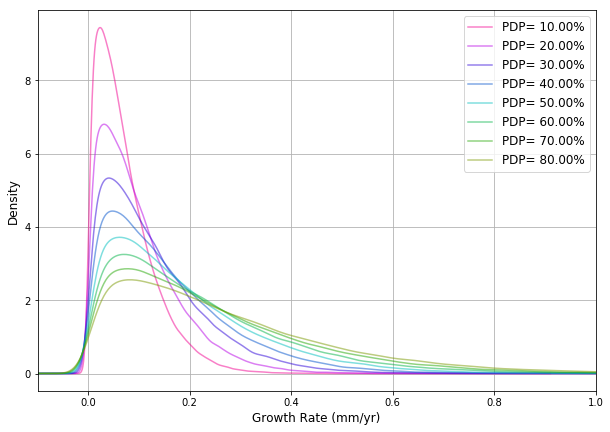

In [76]:
from matplotlib.colors import hsv_to_rgb

def plot_weibull(pdf, ax):
    depthScale = 0.3
    shp, scl = 1.24959, 0.107359 + depthScale * ((pdf-0.2))
    temp = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=shp,scl=scl), columns=[f'PDP= {pdf*100:.2f}%'])
    temp.plot.kde(grid=True, color=tuple(hsv_to_rgb((1-pdf,1,1-pdf/2))), alpha=0.5, ax=ax)
    
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_xlim(-0.1,)

for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    plot_weibull(i,ax)

ax.legend(fontsize=12)
ax.set_xlabel('Growth Rate (mm/yr)', fontsize=12)
ax.set_ylabel('Density',fontsize=12)

In [39]:
hsv_to_rgb((1,1,1000))

array([1000.,    0.,    0.])

# Choice of Grade Distributions 

In [ ]:
qq = """select ld2.code [spec], sum(abs(ps.EndStationNum-ps.BeginStationNum)) [length] from PipeSegment ps
        join stationseries ss on ps.beginstationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        join listdomain ld on ll.lineloopstatusld = ld.id
        join ListDomain ld2 on ps.PipeSpecificationDomainId = ld2.Id
        where ps.EffectiveEndDate is null and ld.code = 'O'
        group by ld2.code
        order by length desc"""

qq2 = """select ps.PipeGrade, sum(abs(ps.EndStationNum-ps.BeginStationNum)) [length] from PipeSegment ps
        join stationseries ss on ps.beginstationseriesid = ss.id
        join lineloop ll on ss.lineloopid = ll.id
        join listdomain ld on ll.lineloopstatusld = ld.id
        where ps.EffectiveEndDate is null and ld.code = 'RISK2019'
        group by ps.PipeGrade
        order by length desc"""

# sql_query(qq).set_index('spec').assign(pct = lambda x: x.length/x.length.sum()).pct.plot(kind='bar')
display(sql_query(qq2).apply(lambda x: round(x/6.89476,0) if x.name == 'PipeGrade' else x).set_index('PipeGrade').assign(pct = lambda x: x.length/x.length.sum()))
sql_query(qq2).apply(lambda x: round(x/6.89476,0) if x.name == 'PipeGrade' else x).set_index('PipeGrade').assign(pct = lambda x: x.length/x.length.sum()).pct.plot(kind='bar')

Variable | Distribution Type | Mean | COV,% | Source | Recommended
---      |---                |---   |---    |:------:|---
SMYS|Normal|1.11|3.4|Jiao et al (1997) API 5L X60 <br>_*Based on 760 tests from different mills._ | 
SMYS|Normal|1.08|3.3|Jiao et al (1997) API 5L X65 <br>_*Based on 2753 tests from different mills._ | 
SMYS|N/A|1.07<br>-<br>1.10|2.6<br>-<br>3.6|Jiao et al (1995b) API 5L X80 <br>_*Based on three sets of tests._ |
SMYS|Lognormal|1.08|4.0|Sotberg and Leira (1994) <br>_*No information on original source provided._|
SMYS|Normal <br>or <br>Lognormal|1.10|3.5|Proprietary data <br>_*Based on mill data for API 5L X60 to X70 pipe._| X

>_"Published distributions of yield and tensile strength are based on data from routine mill tests and are generally not sensitive to steel grade. Jiao et al. (1997) show that the COV can vary by a factor of two depending on the quality of the mill and therefore mill-specific data should be used where possible."_

CSA Z662 2019, Annex O, Page 695

Normal or Lognormal curve appears to cover the broadest range of pipe. Would need to see what could be done for:
* X52 (42.14% of RISK2019 pipe)
* X42 (11.91% of RISK2019 pipe)
* X56 (9.85% of RISK2019 pipe)
* X46 (6.88% of RISK2019 pipe)
* X30 (2.12% of RISK2019 pipe)
* X35 (1.11% of RISK2019 pipe)

# Creating Weibull Distribution

In [ ]:
cgrs = np.array([0.0]+[0.02]+[0.04]+[0.06]+[0.08]+[0.10]+[0.12]+[0.14]+[0.16]+[0.18]+[0.20]+[0.22]+[])

In [ ]:
# from scipy.stats import gamma
# data_gamma = gamma.rvs(a=0.3, size=100000)

# ax = sns.distplot(data_gamma,
#                   kde=True,
#                   bins=100,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1})
# ax.set(xlabel='Gamma Distribution', ylabel='Frequency', xlim=(0,0.5))

# weibullCGR = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=1.439,scl=0.1), columns=['Weibull Distribution'])
weibullCGR = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=1.9,scl=0.12), columns=['Weibull Distribution'])
display(weibullCGR.describe())
ax = weibullCGR.plot.kde(grid=True, color='blue', alpha=0.5, xlim=[-0.05,0.4])
ax2 = weibullCGR.plot.hist(bins = 50, grid=True, color='blue', alpha=0.5, xlim=[-0.05,0.4])

In [ ]:
def get_features_for_cgr_analysis(start=1, amt=4_200_000):
    q = f"""set nocount on;
            select * from
            (
            select
            ROW_NUMBER() over(order by f.id asc) as [RN],
            --ll.Id as 'LineLoopId',
            --f.Id,
            --(mlvc.factornum+f.StationNum*mlvc.MultiplierNum) as 'chainage_m',
            f.ILIFPeakDepthPct,
            f.ILIFSurfaceInd,
            r.ILIRStartDate,
            --a.LineID,
            a.PipeInserviceDate,
            a.PipeWallThickness
            --a.begin_ps,
            --a.end_ps
            from InlineInspectionFeature f
            join ListDomain ld on f.ILIFStatusDomainId = ld.Id
            join MLVCorrection mlvc on f.StationSeriesId = mlvc.StationSeriesId
            join InlineInspectionRange r on f.InlineInspectionRangeId = r.Id
            join StationSeries ss on f.StationSeriesId = ss.Id
            join LineLoop ll on ss.LineLoopId = ll.id
            inner join ( select ll.Id [LineID], ps.PipeWallThickness, ps.PipeInserviceDate, (ps.BeginStationNum*mlv1.MultiplierNum+mlv1.FactorNum) [begin_ps], (ps.EndStationNum*mlv2.MultiplierNum+mlv2.FactorNum) [end_ps] from PipeSegment ps
                        join MLVCorrection mlv1 on ps.BeginStationSeriesId = mlv1.StationSeriesId
                        join MLVCorrection mlv2 on ps.EndStationSeriesId = mlv2.StationSeriesId
                        join StationSeries ss on ps.BeginStationSeriesId = ss.Id
                        join LineLoop ll on ss.LineLoopId = ll.Id ) a on a.LineID = ll.Id and (mlvc.factornum+f.StationNum*mlvc.MultiplierNum) between a.begin_ps and a.end_ps
            where
            ld.code = 'Active'
            ) sub
            where sub.RN between {start} and {start+amt}
            order by sub.RN asc
            """
    return sql_query(q)

In [ ]:
%%time
cgr_df = get_features_for_cgr_analysis(1,4191677)

cgr_df.info(memory_usage='deep')

cgr_df.describe(include='all')

cgr_df.loc[:, 'time_delta'] = ((cgr_df.ILIRStartDate - cgr_df.PipeInserviceDate).dt.days/365.25)
cgr_df.loc[:, 'growth_rate_mmpyr'] = (cgr_df.ILIFPeakDepthPct*cgr_df.PipeWallThickness)/(0.5*cgr_df.time_delta)

cgr_df.query("growth_rate_mmpyr <= 0")

# shp_data, scl_data = weibull_fitter(cgr_df.loc[:,['growth_rate_mmpyr']])
shp_data, scl_data = 1.24959, 0.107359

plt.rcParams.update({'font.size': 20, 'font.family': ['Times New Roman']})
bincount = 75
weibullCGR_1 = pd.DataFrame(cgr.cgr_weibull(np.random.rand(100000),shp=shp_data,scl=scl_data), columns=['PPL Data Weibull Distribution'])
display(weibullCGR_1.describe())
ax = weibullCGR_1.plot.kde(grid=True, color='darkblue', alpha=0.5, xlim=[0,0.4])
ax.get_legend().remove()
ax.set_xlabel("Growth Rate")

# ax2 = weibullCGR_1.plot.hist(bins=bincount, color='cyan', alpha=0.5, xlim=[0,0.4])


In [ ]:
weibullCGR_1.quantile(0.95)